In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer


from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

In [2]:
train = pd.read_csv('../data/train_clean.csv')
weather = pd.read_csv('../data/weather_cleaned.csv')

# Contents
- [Cleaning Train Dataset](#Cleaning-Train-Dataset)
- [Cleaning Test Dataset](#Cleaning-Test-Dataset)
- [Cleaning Weather Dataset](#Cleaning-Weather-Dataset)
- [Cleaning Spray Dataset](#Cleaning-Spray-Dataset)

In [3]:
merge_train_weather = train.merge(weather, on = 'date', how = 'inner')

In [4]:
merge_train_weather.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'sunrise', 'sunset', 'bc', 'br',
       'dz', 'fg', 'fg+', 'fu', 'gr', 'hz', 'mi', 'ra', 'sn', 'sq', 'ts',
       'vc'],
      dtype='object')

In [5]:
continuous_var = ['latitude','longitude','nummosquitos','wnvpresent','month_num','tmax','tmin','tavg','dewpoint','wetbulb','heat','cool','preciptotal','stnpressure','sealevel','resultspeed',
 'resultdir','avgspeed','sunrise','sunset','bc','br','dz','fg','fg+','fu','gr','hz','mi','ra','sn','sq','ts','vc']
continuous_var1 = ['nummosquitos','sunrise','sunset','tavg','dewpoint','wetbulb','heat','cool','preciptotal','stnpressure','sealevel','resultspeed',
 'resultdir','avgspeed','bc','br','dz','fg','fg+','fu','gr','hz','mi','ra','sn','sq','ts','wnvpresent']

In [6]:
impt_features = merge_train_weather[continuous_var1]

In [7]:
# defining lasso regression to better book kepe journal.
# outputs are X_train, X_test, y_train, y_test, lasso_best
# included indices as well in order to find outliers 

def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series
    indices = X_df.index.values
    
    # Create train/test splits.
    X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
        X,
        y,
        indices,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=90000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 
    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    print(f'Lasso alpha used: {lasso.alpha_}')
    
    return X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test

In [8]:
X = impt_features.drop(columns = ['wnvpresent','nummosquitos'])
y = impt_features['nummosquitos']

In [9]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best,indices_train, indices_test= lasso_reg(
    X_df = X,
    y_series = y,
    test_size = 0.3
)

MSE for train: 5228.60619526174
MSE for test: 6466.4962725773
Overfitted by: -1237.8900773155601
RMSE: 80.41452774578298
Lasso alpha used: 0.03341308659927716


<AxesSubplot:>

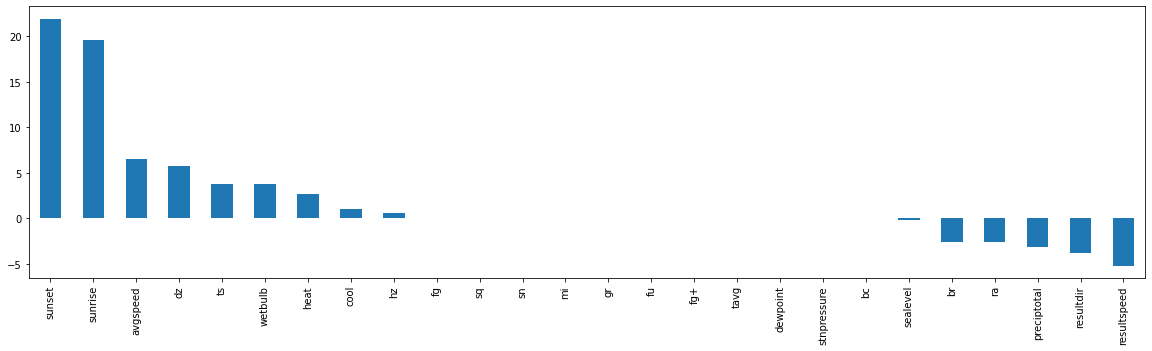

In [10]:
# to plot the series 
# too many variables, need to scale down the number of features 
plt.figure(figsize=(20,5))

col = X.columns
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

Checking code sum should only have these based on Daily Table format given by Kaggle 

`TS` - Thunderstorm

`RA` - Rain

`FG` - Fog

`FG+` - Heavy Fog 

`BR` - Mist

`DZ` - Drizzle 

`HZ` - Haze




In [11]:
heatmap_df = pd.DataFrame(impt_features.drop(columns = ['bc', 'fg+', 'fu','gr','mi', 'sn','sq']))
heatmap_df = heatmap_df.rename(columns= {'ts' : 'thunderstorm', 'ra': 'rain', 'fg': 'fog', 'fg+': 'heavy_fog', 'br': 'mist', 'dz': 'drizzle', 'hz': 'haze'})

<AxesSubplot:>

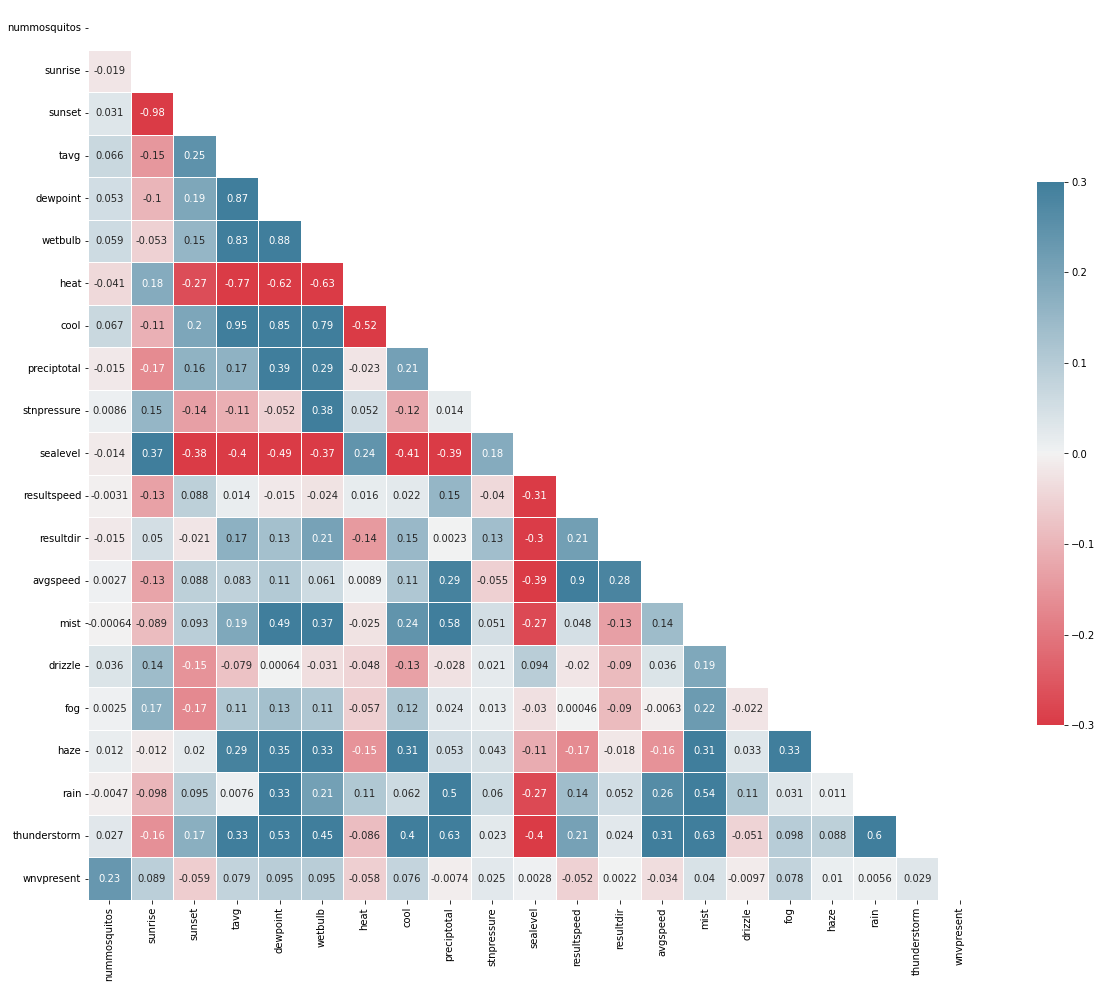

In [12]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(heatmap_df.corr()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(heatmap_df.corr(), mask=mask, cmap=cmap, vmax=0.3, vmin = -0.3,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot = True)

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

From the heatmap, few observations were observed. 

1) Generally, having thunderstorm, haze, fog, drizzle have a positive correlation with number of mosquitoes and wnv present. 
2) Generally, 

According to ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7068582/))

- Humidity positive correlation with daily temperature 
- 